##Lecture 5: Simple Recurrent Network

Recurrent neural networks (RNNs) model dynamic systems.  (This is not the same as a "recursive" network which is a nested network structure.)  A typical dynamic system has equations of the form:
\begin{equation}
\dot{x} = Ax + Bu \\
y = Cx
\end{equation}
where $x$ is the state, $u$ is the input, and $y$ is the observed output. In discrete time, we have:
\begin{equation}
x(t+1) = Ax(t) + Bu(t) \\
y(t+1) = Cx(t+1)
\end{equation}

There are many uses of dynamic systems.  One is as a filter, in which the goal is to infer $x$ from observations of $y$ (which is usually lower-dimensional).  This is the basis of a Kalman filter.  In a Kalman filter, we assume that we know $A$, $B$, and $C$, that $u$ is noise, and we create an estimate $\hat{x}$ of $x$ at each step. We then create a predicted observation $\hat{y} = C\hat{x}$, and use the error $y-\hat{y}$ to correct our estimate of $\hat{x}$, so that $\hat{x}(t+1) = K(y-\hat{y})$ where $K$ is the "Kalman Gain" and is derived from knowledge of the system noise.

Another use is in system identification, where we take measurements of $y$ and $u$, and use the Laplace transforms to estimate the transfer function $Y(s) = H(s)U(s)$, or $H(s) = U(s)/Y(s)$.  Then we find a ratio of polynomials in $s$ that approximate the transfer function
\begin{equation}
H(s) \approx \frac{b_0 + b_1s + b_2 s^2 + \ldots}{1 + a_1s + a_2s^2 + \ldots}
\end{equation}
which is consistent with the ARMA model
\begin{equation}
y + a_1y' + a_2y'' +\ldots = b_0u + b_1u' + b_2u'' + \ldots
\end{equation}
which can be written as a state-space model of the form
\begin{equation}
y = -a^T<y', y'', ...> + b^T<u, u', u'', ...> \\
y' = y' \\
\ldots\\
\dot{\cal Y} = A{\cal Y} + B{\cal U}
\end{equation}
where the rows beyond the first represent the relationship between the various derivatives.

The point is that we frequently end up with equations that look like 
\begin{equation}
\dot{x} = Ax + Bu, y=Cx \\
x(t+1) = Ax(t) + Bu(t), y(t+1) = Cx(t+1)
\end{equation}

So here we are going to use the Keras "SimpleRnn" model to create exactly this kind of structure (in the discrete-time domain).  How does this work?  SimpleRnn implements the following equation:
\begin{equation}
x(t+1) = Ax(t) + Bu(t)
\end{equation}
The input is $u(t), u(t-1), \ldots u(t-N)$ for some "predict_length" $N$.   The output is $x(t+1)$ at a single time. (You could output $x(t)$ at all intermediate times, but that would just be a standard memoryless mapping). The point is that $x(t)$ is not memoryless, but in fact depends on the prior values of $x(t-n)$, and there uses memory of the last $N$ samples, where this memory is stored in the "state" $x$. 

How does SimpleRNN do this?  Each "hidden unit" actually has memory of its own past state.  So at time $t$, each hidden unit in the RNN looks at the current input $u(t)$ but also looks at its own prior value $x(t-1)$.  There are weights from both inputs, so that $x(t) = Ax(t-1) + Bu(t-1)$. So this exactly implements the idea of a dynamic system.  It is up to us to read out the output using another "dense" layer to obtain $\hat{y}(t) = Cx(t)$.  We could calculate errors at every time step comparing the true output to the predicted output $y-\hat{y}$, but typically we only do this for the "final" output, or after a finite number of time steps.  Why do that?  Because it forces the network to learn a good update matrix $A$.  If you always have access to the correct output, you might not have to learn to make the iterated predictions $x(t+1) = Ax(t)$.  So we only look at $y(t_{final})$.  

Then we use "backpropagation through time" to figure out $A$ and $B$.   How does that work?  Well, we need an initial $x(0)$ (usually zero, but could be taken from a previous estimate). Then that "forward propagates" through the $A$ matrix a few times to get $x(t+N) = A^Nx(0)$.  At each step we add in $Bu(t)$.  So we can backpropagage the final error $y(t+N)-\hat{y}(t+N)$ through the $A$ matrix (which is the same at each time step) and the $B$ matrix (back to different values of $u(t)$ at each time step, subject to the constraint that there is only one $A$ and one $B$ matrix.  

Note that this is different from the Kalman filter formulation, and closer to system identification, because we learn the $A$ and $B$ matrices, rather than assuming we know them in advance.  At the same time we learn the values for the hidden state $x$. We will have to assume we know the dimension of $x$, but we can try multiple different sizes for that to see what works.




In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import seaborn as sns
import tensorflow as tf

#for your homework
np.random.seed(10327798)
tf.random.set_seed(10327798)

In [218]:
#use the EEG dataset that we used for Lecture 1.
# in this case, we use all 14 channels so that this is multivariate timeseries
# the input u(t) is a vector at each point in time <u_1(t), u_2(t), .... u_14(t)>
from sklearn.datasets import fetch_openml
eeg = fetch_openml(data_id=1471,as_frame= True )
#this timeseries dataset does not actually include time.  So we will synthesize timestamps
increment = 117 / len (eeg[ 'data' ])
index = np.linspace(
start= 0 ,
stop=increment* len (eeg[ 'data' ]),
num= len (eeg[ 'data' ])
)
ts_index = pd.to_datetime(index, unit= 's' ,origin = '2022-1-3 15:30:00')  #convert to seconds

In [219]:
#make a dataframe out of this. Series usually only have a single value;  we need a dataframe for all 14.
#   remember that dataframes look like spreadsheets.
eeg_df = pd.DataFrame(data=eeg[ 'data' ].values, index=ts_index)  
eeg_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
2022-01-03 15:30:00.000000000,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85
2022-01-03 15:30:00.007810831,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10
2022-01-03 15:30:00.015621901,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23
2022-01-03 15:30:00.023432732,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41
2022-01-03 15:30:00.031243801,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-03 15:31:56.968756199,4281.03,3990.26,4245.64,4116.92,4333.85,4614.36,4074.87,4625.64,4203.08,4221.54,4171.28,4269.23,4593.33,4340.51
2022-01-03 15:31:56.976567268,4276.92,3991.79,4245.13,4110.77,4332.82,4615.38,4073.33,4621.54,4194.36,4217.44,4162.56,4259.49,4590.26,4333.33
2022-01-03 15:31:56.984378099,4277.44,3990.77,4246.67,4113.85,4333.33,4615.38,4072.82,4623.59,4193.33,4212.82,4160.51,4257.95,4591.79,4339.49
2022-01-03 15:31:56.992189169,4284.62,3991.79,4251.28,4122.05,4334.36,4616.41,4080.51,4628.72,4200.00,4220.00,4165.64,4267.18,4596.41,4350.77


In [220]:
# there is an artifact at 1:10, so select a slice of time before
slicing = (eeg_df.index >= '2022-1-3 15:30:08' ) & (eeg_df.index <= '2022-1-3 15:31:10.000000000' )
#the result is still a pandas series, with timestamp, value pairs.

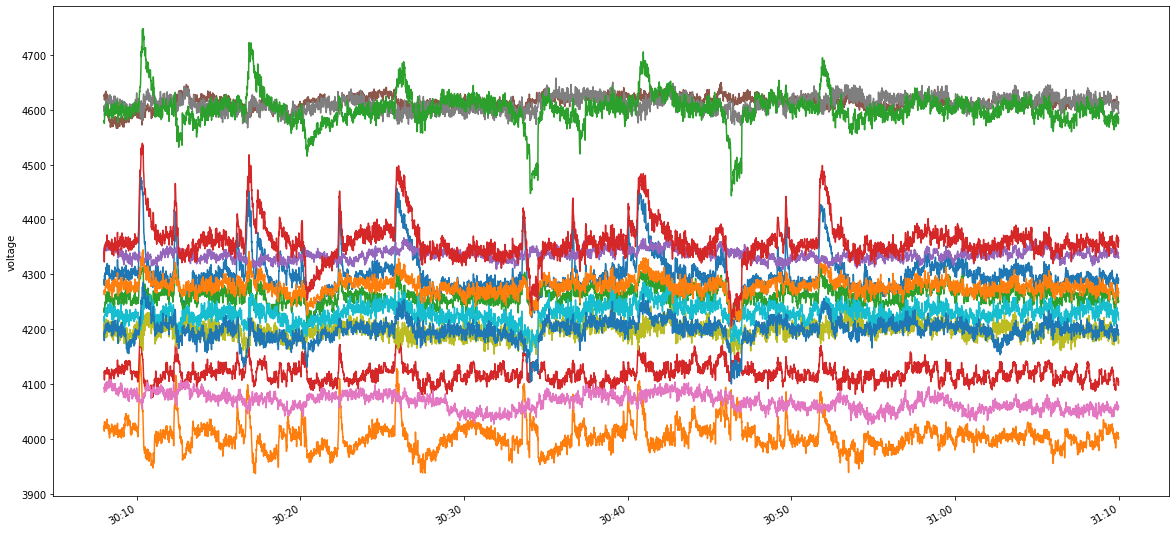

In [221]:
#same time formatter we used before.  look at the raw data
date_formatter = DateFormatter( "%M:%S" )  #just show minutes:seconds
ax = eeg_df.loc[slicing,0].plot(figsize=( 20 , 10 ))  #will use the same axes for all; set dateformatter based on first
plt.plot(eeg_df.loc[slicing,1:13])   #there are 14 columns total
ax.xaxis.set_major_formatter(date_formatter)
plt.ylabel( 'voltage' );



In [222]:
#scale the range.  scale separately for each of the 14 data channels
from sklearn.preprocessing import StandardScaler   #use standard normal (mean 0, std 1) rather than min/max scaler here
scaler = StandardScaler()
scaler.fit(eeg_df[slicing])  #use only the sliced data for the fit
eeg_scaled = scaler.transform(eeg_df[slicing])  #from here on we use only the sliced data
eeg_scaled_df= pd.DataFrame(data=eeg_scaled, index=ts_index[slicing])
eeg_scaled_df[0:10]  #take a look

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
2022-01-03 15:30:08.006208658,-0.266739,0.735518,-1.557530,0.192408,1.088466,0.964741,1.630955,-0.991542,-0.308114,-0.464933,-0.228375,-0.513778,-0.716078,-0.520897
2022-01-03 15:30:08.014019728,-0.425490,0.513663,-2.080956,0.030059,0.707039,1.143768,1.733216,-0.254797,1.023512,-0.821951,-0.625475,-0.757114,-0.819031,-0.848184
2022-01-03 15:30:08.021830559,-0.540894,0.372447,-1.941421,-0.652950,0.870660,0.964741,1.698687,-0.293374,0.357317,-1.081486,-0.995758,-1.035697,-0.870508,-1.033184
2022-01-03 15:30:08.029641390,-0.266739,0.715063,-1.836600,-0.750613,1.361521,0.293170,1.120311,-1.496068,-0.974309,-0.789035,-0.546055,-0.861498,-0.613125,-0.620470
2022-01-03 15:30:08.037452459,-0.021295,1.058073,-1.522816,-0.099948,1.741885,0.427659,1.221909,-1.689709,-0.425768,-0.237682,0.035670,-0.410072,-0.304600,-0.250747
2022-01-03 15:30:08.045263290,-0.107988,0.876734,-1.138925,0.322414,1.905505,1.099229,2.005471,-0.952965,0.240427,-0.237682,-0.096353,-0.444640,-0.304600,-0.407179
2022-01-03 15:30:08.053074360,-0.266739,0.573847,-1.138925,0.062402,1.633513,1.099229,2.005471,-1.069452,-0.308114,-0.367449,-0.255193,-0.479209,-0.390505,-0.464038
2022-01-03 15:30:08.060885191,-0.252103,0.654879,-1.208352,-0.067605,1.197900,0.875664,1.460298,-1.457491,-0.269151,-0.269965,-0.122654,-0.410072,-0.356076,-0.364465
2022-01-03 15:30:08.068696260,-0.064642,0.796095,-0.929283,0.160065,1.142652,0.516736,1.494827,-0.991542,0.436008,-0.204765,-0.228375,-0.618161,-0.339029,-0.407179
2022-01-03 15:30:08.076507092,0.094109,0.856279,-0.824461,0.257728,1.524079,0.516736,1.834814,-0.564926,0.279391,-0.237682,-0.281494,-0.722545,-0.339029,-0.449893


#TimeSeriesGeneratorn for multivariate data passed to an RNN
this is a bit special.  The reason is that the RNN is trained on lagged data values $u(t) \ldots u(t-N)$.  But this is not the same as the "predict_length" variable we used in the past.  predict_length = 5 means that we use the last 5 data samples as 5 separate inputs to the network.  For a univariate timeseries, this means the network would have 1x5 = 5 inputs, or for a multivariate network 14x5 = 70 inputs, each with its own weight.

But for an RNN, the situation is different.  We predict over several steps, but the weights for each step are the same.  So we need to make sure that we present the data to the network in the correct format.

Here is the relationship between predict_length and batch_size.  predict_length = 5 says we look back 5 time steps to predict a single output.  batch_size = 5 says we predict 5 outputs from 5 time steps.  In other words, this is 5 separate predictions.  Predict_length = 2 and batch_size = 5 means that at each of 5 time steps we look 2 steps back to make 5 separate predictions (one for each time step).  In the case of an RNN, we look back 5 time steps, but we predict only the final output, so batch_size=1, and predict_length =5.

How does the network know not to use 5 past values simultaneously but rather to put them into each time step of the RNN?  Well, that's an assumption that SimpleRNN makes.  It assumes  that you only use one time step at a time.  If you want more, you will have to include those manually.  For SimpleRNN, predict_length means how many time steps back you start the dynamic system.  

So here, for the TimeSeriesGenerator we use predict_length = 14 (coincidentally equal to the dimensionality of the timeseries.  This is because it usually takes at least that many time steps to converge).  We use batch_size=1 because we only have a single target output $y$ at the end of each complete 14-step timeseries.





In [223]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 14
generator14 = TimeseriesGenerator(eeg_scaled_df.values, eeg_scaled_df.values, length =predict_length , batch_size=1)  #use at least 14 points because 14 dimensions
#NOTE1:  you have to use df.values or you get weird indexing errors
#NOTE2:  length=1 because we only use the current input data.  batch_size=14 because we need 14 input/output pairs to train the RNN
generator14[0]

(array([[[-0.26673919,  0.73551812, -1.5575299 ,  0.19240794,
           1.08846593,  0.96474065,  1.63095483, -0.99154169,
          -0.30811384, -0.46493282, -0.22837549, -0.51377758,
          -0.71607808, -0.52089734],
         [-0.42549   ,  0.5136634 , -2.08095593,  0.03005864,
           0.70703924,  1.14376796,  1.73321638, -0.25479724,
           1.02351222, -0.82195121, -0.62547509, -0.75711392,
          -0.81903123, -0.84818406],
         [-0.54089395,  0.37244736, -1.94142103, -0.65294992,
           0.87065961,  0.96474065,  1.6986865 , -0.29337421,
           0.3573172 , -1.08148585, -0.99575757, -1.03569674,
          -0.87050781, -1.03318427],
         [-0.26673919,  0.71506343, -1.83659969, -0.75061317,
           1.3615207 ,  0.29316991,  1.12031112, -1.49606793,
          -0.97430887, -0.78903462, -0.54605517, -0.86149775,
          -0.61312493, -0.62047017],
         [-0.02129468,  1.05807286, -1.52281634, -0.09994763,
           1.74188492,  0.42765872,  1.2219086

Note above that there are 14 samples of each of the 14 variables, but only a single output of the 14 variables which is the target.

When we build the SimpleRNN network model, we use predict_length as the input, but remember that for SimpleRNN this means the number of iterated samples, each of predict_length=1, that are actually used as input to the network.

We also use n_features as the final output from the network because we are trying to predict the next 14 channels of EEG.

You can calculate the total number of parameters.  There are 14 inputs, 4 hidden units, and a bias unit for each of the hidden units.  There are also 16 weights that map each of the hidden units $x(t)$ onto those same hidden units at $x(t+1)$.  So we have 14x4 + 4 + 4x4 = 76 weights in the SimpleRNN layer.  Then for each of the 4 units in the RNN layer, we have 14 outputs plus 14 bias terms, which is 4x14 + 14 = 70.

In [224]:
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.layers import LSTM, SimpleRNN
n_features = 14
n_hidden = 4
model = Sequential()
model.add(SimpleRNN(n_hidden, activation='linear', input_shape=(predict_length, n_features)))  #feel free to use 'sigmoid' or 'relu' units
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_26 (SimpleRNN)   (None, 4)                 76        
                                                                 
 dense_27 (Dense)            (None, 14)                70        
                                                                 
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [225]:
model.fit(generator14,epochs=3)

Epoch 1/3
7923/7923 [==============================] - 26s 3ms/step - loss: 0.4683
Epoch 2/3
7923/7923 [==============================] - 25s 3ms/step - loss: 0.2475
Epoch 3/3
7923/7923 [==============================] - 25s 3ms/step - loss: 0.2389


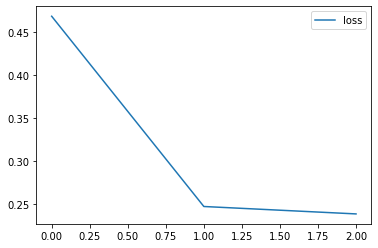

In [226]:
losses = pd.DataFrame(model.history.history)
losses.plot()

Let's look at the weights. The first layer is the weights from the 14 inputs to the 4 hidden units.  This is the $B$ matrix. The next is the weights from the 4 hidden units back to themselves at the next time.  This is the $A$ matrix. So we have $x(t+1) = Ax(t) + Bu(t)$  The next is the weights from the 4 hidden units to the 14 outputs, this is the $C$ matrix, giving $y(t+1) = Cx(t+1)$.  And you have the 4 biases to the hidden units and 14 biases to the outputs.  

In [227]:
model.weights

[<tf.Variable 'simple_rnn_26/simple_rnn_cell_26/kernel:0' shape=(14, 4) dtype=float32, numpy=
 array([[ 0.22319934, -0.43226248, -0.4563393 , -0.2251211 ],
        [-0.473179  , -0.44391564, -0.53942466,  0.04600881],
        [-0.12170005, -0.11224663, -0.5144008 , -0.2104383 ],
        [-0.3930061 , -0.31507945, -0.5543887 , -0.02277444],
        [-0.6762869 , -0.28402093,  0.5145276 , -0.5067193 ],
        [-0.5302397 ,  0.09536473,  0.35445186, -0.47888038],
        [-0.09549743,  0.6288466 , -0.72291416, -0.11618207],
        [ 0.11213343,  0.52558446, -0.15704931, -0.2181889 ],
        [ 0.04635843,  0.31569505,  0.20077804, -0.48754308],
        [-0.12440439,  0.05035635,  0.26281643, -0.36090416],
        [ 0.18547095, -0.17200759,  0.2952107 , -0.5322951 ],
        [ 0.2122711 ,  0.09438384, -0.36774275, -0.1108297 ],
        [ 0.37277004, -0.44277054,  0.26772174, -0.45431963],
        [ 0.13731696, -0.64650536, -0.2857485 , -0.5000391 ]],
       dtype=float32)>,
 <tf.Variable

In [228]:
#get the model predictions for all timepoints
predicted_outputs = model.predict(generator14)  #this is a 14 element vector for each time point
#convert to dataframes with the correct timestamps.  outputs start at t=predict_length
predict_df = pd.DataFrame(data=predicted_outputs, index=eeg_scaled_df.index[predict_length:])  #14 columns plus the timestamp column
orig_df = pd.DataFrame(data=eeg_scaled_df[predict_length:], index=eeg_scaled_df.index[predict_length:len(eeg_scaled_df)])


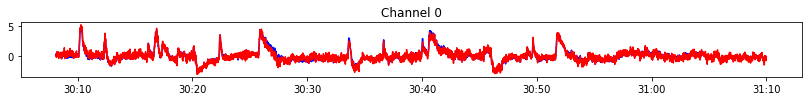

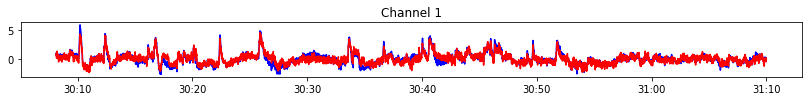

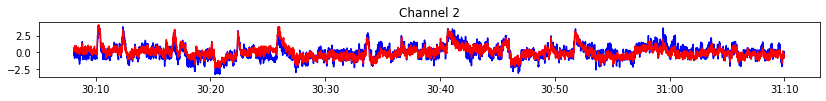

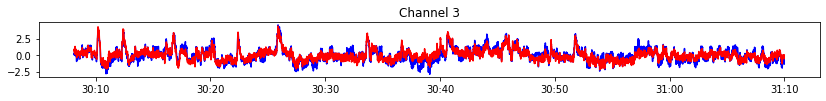

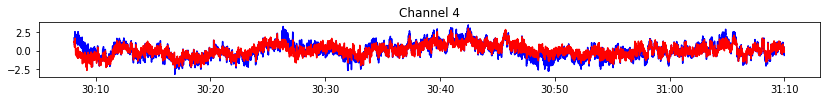

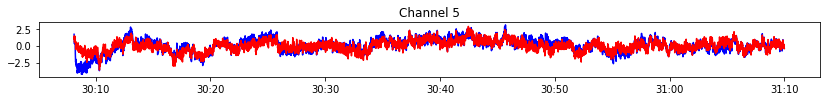

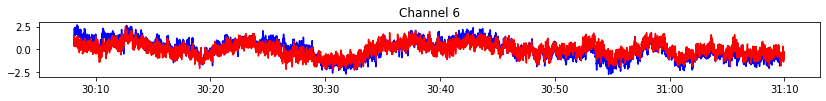

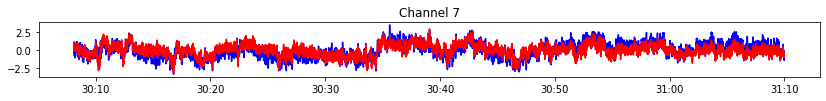

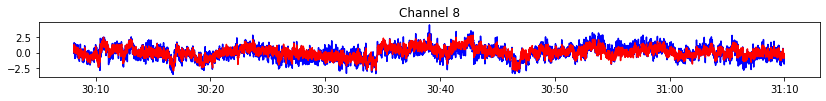

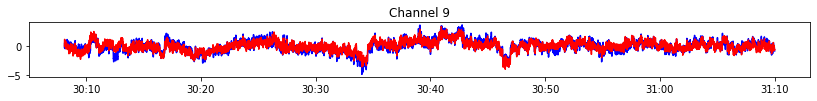

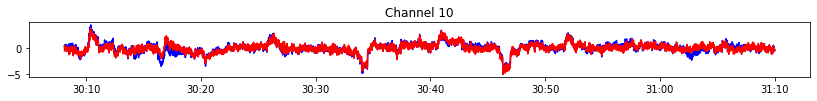

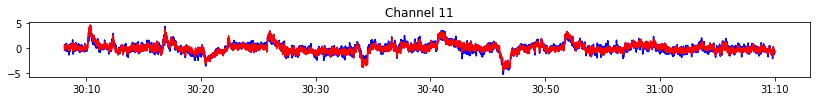

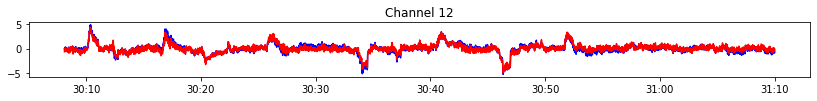

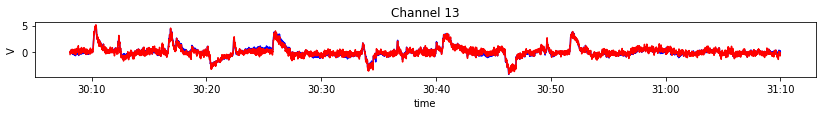

In [229]:
for n in range(n_features):
  plt.figure(figsize=(14,1),linewidth=.1)
  ax = plt.gca()
  ax.xaxis_date()
  ax.xaxis.set_major_formatter(date_formatter)
  plt.plot(orig_df[n],'b')  #compare one column at a time
  plt.plot(predict_df[n],'r')
  plt.title('Channel {}'.format(n))
plt.ylabel('V')
plt.xlabel('time');
  

If you want to play with this, look at using linear, sigmoid, or relu activations in the network, and experiment with differing numbers of hidden units.